# Train/Test/Val LSTM Implementation

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import TextClassificationPipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, Trainer, TrainingArguments
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm
from torch.autograd import Variable
import math
import ast
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, random_split, DataLoader
from sklearn.model_selection import cross_val_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [ ]:
# Import train data
train = pd.read_csv('/content/drive/MyDrive/Zeta Test/train.csv')

# Separate train labels and text
train_labels = train['category']
train_text = train['text']

### Set 50% of the train dataset to be the train set and 50% to be test set, stratifying by the train labels

In [ ]:
# Create a stratified 50% sample of the train data
train_text, test_text, train_labels, test_labels = train_test_split(train_text, train_labels, test_size=0.50, stratify=train_labels, random_state=42)

# Reset the indices of the train_labels and test_labels Series as well as the train_text and test_text
train_labels = train_labels.reset_index(drop=True)
train_text = train_text.reset_index(drop=True)

test_labels = test_labels.reset_index(drop=True)
test_text = test_text.reset_index(drop=True)

### Shuffle 10% of Labels in Dn to Create Noise

In [ ]:
def add_noise(labels, noise_level=0.1, seed=42):
    # Set the seed for the random number generator
    np.random.seed(seed)

    # Get unique labels and their counts
    unique_labels, counts = np.unique(labels, return_counts=True)

    # Calculate the number of labels to change for each unique label
    n_noise_per_label = (noise_level * counts).astype(int)

    # Create a copy of labels to work with
    noisy_labels = labels.copy()

    # Initialize an empty list to store noise indices
    noise_indices = []

    for lbl, n_noise in zip(unique_labels, n_noise_per_label):
      if n_noise == 0: # if none noised, noise one label
        n_noise = 1

      # Get indices of current label
      label_indices = np.where(labels == lbl)[0]

      # Randomly select labels of current label to change
      noise_indices_lbl = np.random.choice(label_indices, size=n_noise, replace=False)

      # Add the noise indices for this label to the main list
      noise_indices.extend(noise_indices_lbl)

      # Get a list of labels excluding the current one
      other_labels = [other_lbl for other_lbl in unique_labels if other_lbl != lbl]

      for idx in noise_indices_lbl:
          # Randomly select a new label
          new_label = np.random.choice(other_labels)

          # Replace the label at the current index with the new label
          noisy_labels[idx] = new_label

    return noisy_labels, np.array(noise_indices)

In [ ]:
# Add noise to train and test labels and get the indices of the noised labels
full_noised_train_labels, train_noise_indices = add_noise(train_labels)
full_noised_test_labels, test_noise_indices = add_noise(test_labels)

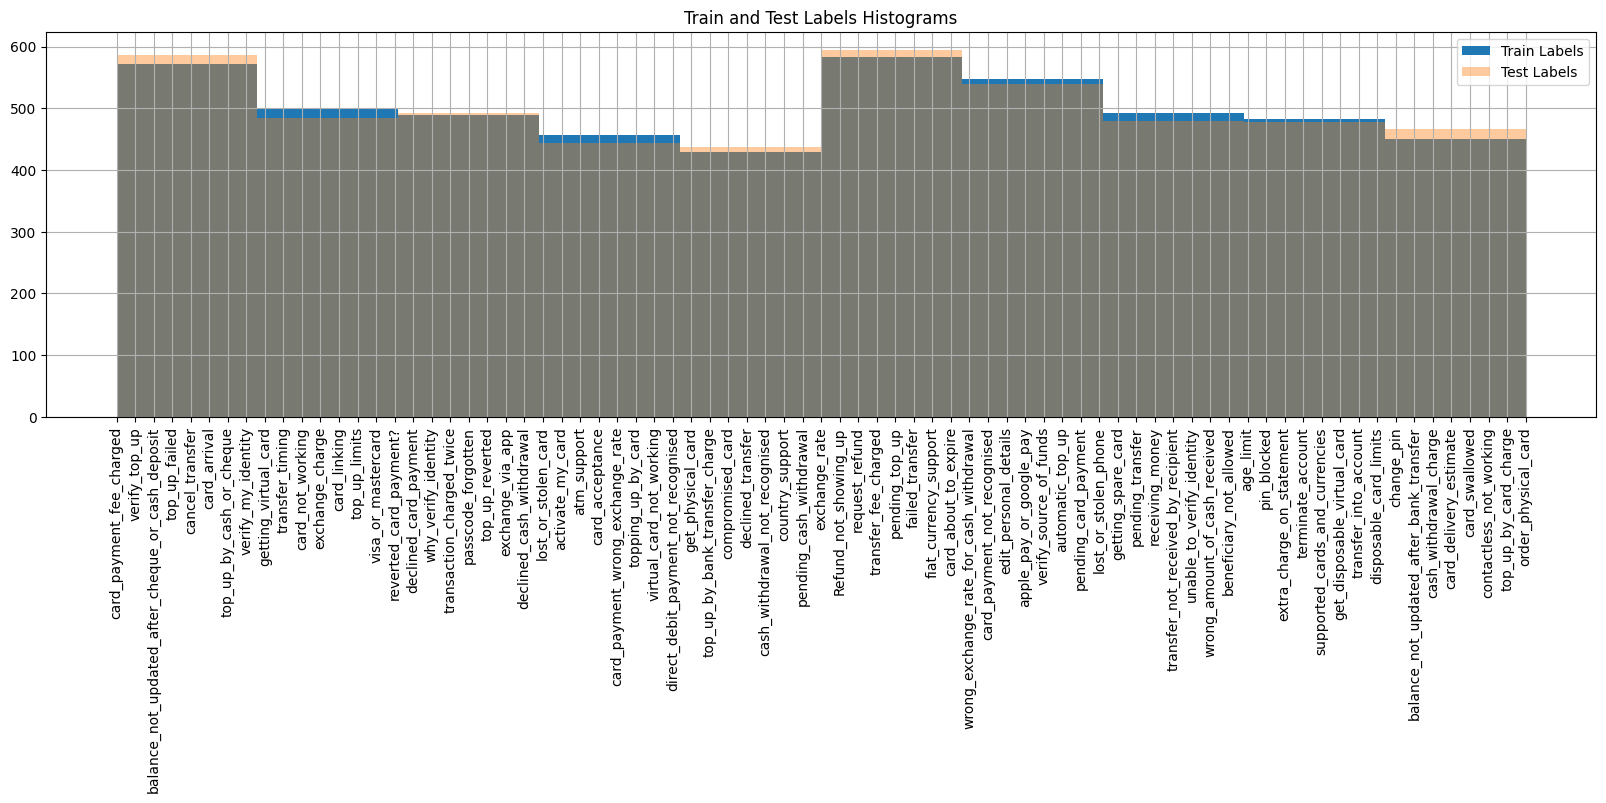

In [ ]:
# Increase the figure width
plt.figure(figsize=(20, 5))

# Plot histogram for train labels
full_noised_train_labels.hist(alpha=1, label='Train Labels')
# Plot histogram for test labels on top of train labels
full_noised_test_labels.hist(alpha=0.4, label='Test Labels')

plt.xticks(rotation='vertical')
plt.legend()
plt.title('Train and Test Labels Histograms')

# Show the plot
plt.show()


In [ ]:
# Create a DataFrame from the train_text and train_labels
df_train = pd.DataFrame({
    'text': train_text,
    'category': full_noised_train_labels,
    'k': 0,
    'l': train_labels,
    'l_prime': full_noised_train_labels
})

# Mark the noised samples in the 'k' column
df_train.loc[train_noise_indices, 'k'] = 1

# Repeat the same process for the test set
df_test = pd.DataFrame({
    'text': test_text,
    'category': full_noised_test_labels,
    'k': 0,
    'l': test_labels,
    'l_prime': full_noised_test_labels
})

# Mark the noised samples in the 'k' column
df_test.loc[test_noise_indices, 'k'] = 1

# Combine the train and test DataFrames
train_test_combined_df = pd.concat([df_train, df_test])

# Display the DataFrame to verify the changes
train_test_combined_df.head(25)

,text,category,k,l,l_prime
0,"On a card payment, why is there a fee?",card_payment_fee_charged,0,card_payment_fee_charged,card_payment_fee_charged
1,Tell me why I need top-up to be verified?,verify_top_up,0,verify_top_up,verify_top_up
2,i used a check check yesterday to balance my a...,balance_not_updated_after_cheque_or_cash_deposit,0,balance_not_updated_after_cheque_or_cash_deposit,balance_not_updated_after_cheque_or_cash_deposit
3,I believe my top up has failed,top_up_failed,0,top_up_failed,top_up_failed
4,How to cancel a transaction,cancel_transfer,0,cancel_transfer,cancel_transfer
5,Is there a way I can get my card expedited?,card_arrival,0,card_arrival,card_arrival
6,Am I able to top up with this cheque I received?,top_up_by_cash_or_cheque,0,top_up_by_cash_or_cheque,top_up_by_cash_or_cheque
7,What can I use to verify my identity?,verify_my_identity,0,verify_my_identity,verify_my_identity
8,Please tell me how I can get a virtual card.,getting_virtual_card,0,getting_virtual_card,getting_virtual_card
9,I paid with my card so so why was I charged a ...,card_payment_fee_charged,0,card_payment_fee_charged,card_payment_fee_charged


In [ ]:
sum(train_test_combined_df['k']==1)/len(train_test_combined_df)

0.09357192842147356

## Step 1: Define and Train Deep Model

In [ ]:
device_name = 'cuda'
model_name = 'bert-base-uncased'

# Tokenize input text
tokenizer = BertTokenizer.from_pretrained(model_name)

# Tokenize and encode the training text
train_input_text = np.array(train_text)
train_input_ids = tokenizer.batch_encode_plus(train_input_text, padding=True, truncation=True, return_tensors='pt')['input_ids']
train_attention_mask = tokenizer.batch_encode_plus(train_input_text, padding=True, truncation=True, return_tensors='pt')['attention_mask']

# Tokenize and encode the testing text
test_input_text = np.array(test_text)
test_input_ids = tokenizer.batch_encode_plus(test_input_text, padding=True, truncation=True, return_tensors='pt')['input_ids']
test_attention_mask = tokenizer.batch_encode_plus(test_input_text, padding=True, truncation=True, return_tensors='pt')['attention_mask']

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(full_noised_train_labels)
test_labels_encoded = label_encoder.transform(full_noised_test_labels)  # Use transform for test labels

# Convert encoded labels to tensors
train_labels = torch.tensor(train_labels_encoded)
test_labels = torch.tensor(test_labels_encoded)

# Get the indices of the noised data for test set
test_noise_indices = test_noise_indices
test_noise_indices_tensor = torch.tensor(test_noise_indices)

# Create boolean masks for the noised and non-noised data for test set
mask_noised_test = torch.zeros(test_labels.size(0), dtype=torch.bool)
mask_noised_test[test_noise_indices_tensor] = True
mask_non_noised_test = ~mask_noised_test

# Create TensorDatasets for the noised and non-noised parts of the test set
test_dataset_noised = TensorDataset(test_input_ids[mask_noised_test], test_attention_mask[mask_noised_test], test_labels[mask_noised_test])
test_dataset_non_noised = TensorDataset(test_input_ids[mask_non_noised_test], test_attention_mask[mask_non_noised_test], test_labels[mask_non_noised_test])

# Get the indices of the noised data for train set
train_noise_indices = train_noise_indices
train_noise_indices_tensor = torch.tensor(train_noise_indices)

# Create boolean masks for the noised and non-noised data for train set
mask_noised_train = torch.zeros(train_labels.size(0), dtype=torch.bool)
mask_noised_train[train_noise_indices_tensor] = True
mask_non_noised_train = ~mask_noised_train

# Create TensorDatasets for the noised and non-noised parts of the train set
train_dataset_noised = TensorDataset(train_input_ids[mask_noised_train], train_attention_mask[mask_noised_train], train_labels[mask_noised_train])
train_dataset_non_noised = TensorDataset(train_input_ids[mask_non_noised_train], train_attention_mask[mask_non_noised_train], train_labels[mask_non_noised_train])

# Create TensorDatasets for the full train and test sets
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)

In [ ]:
# from safetensors.torch import load_file
# from transformers import BertModel
# file_path = "/content/drive/MyDrive/Zeta Test/model.safetensors"
# loaded = load_file(file_path)

# model = BertModel.from_pretrained(loaded)

In [ ]:
# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device_name), attention_mask.to(device_name), labels.to(device_name)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)  # Calculate cross-entropy loss
            total_loss += loss.item()

            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)  # Calculate probabilities from logits
            preds = torch.argmax(probs, dim=1)  # Get predictions from probabilities

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(dataloader), all_preds, all_labels

In [ ]:
# Load pre-trained model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=77).to(device_name)

# Define optimizer with Adam
optimizer = AdamW(model.parameters(), lr=7e-6, weight_decay=4e-4)

# Define loss function (cross-entropy loss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define training parameters
num_epochs = 30
batch_size = 32

# DataLoader for training set and test set as well as un-noised test and noised test
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_noised = DataLoader(train_dataset_noised, batch_size=batch_size, shuffle=True)
train_loader_non_noised = DataLoader(train_dataset_non_noised, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_loader_noised = DataLoader(test_dataset_noised, batch_size=batch_size, shuffle=True)
test_loader_non_noised = DataLoader(test_dataset_non_noised, batch_size=batch_size, shuffle=True)

# Initialize a DataFrame to store the probabilities
probabilities_df_dn = pd.DataFrame()
all_preds = []

epoch_true_probs_dn = pd.DataFrame()

epoch_true_probs_noised_train = pd.DataFrame()
epoch_true_probs_noised_test_df = pd.DataFrame()
epoch_true_probs_non_noised_train = pd.DataFrame()
epoch_true_probs_non_noised_test_df = pd.DataFrame()

epoch_train_noised_df = pd.DataFrame()
epoch_train_non_noised_df = pd.DataFrame()
epoch_test_noised_df = pd.DataFrame()
epoch_test_non_noised_df = pd.DataFrame()

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    epoch_probs = []  # List to store probabilities for this epoch
    epoch_true_probs = []  # List to store true probabilities for this epoch

    epoch_true_probs_noised = []
    epoch_true_probs_non_noised = []
    epoch_true_probs_noised_test = []
    epoch_true_probs_non_noised_test = []

    epoch_train_noised = []
    epoch_train_non_noised = []
    epoch_test_noised = []
    epoch_test_non_noised = []

    # Iterate through train
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device_name), attention_mask.to(device_name), labels.to(
            device_name)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)  # Calculate cross-entropy loss
        total_loss += loss.item()

        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Calculate probabilities from logits
        true_label_probs = probs[range(len(labels)), labels].detach().cpu().numpy()
        epoch_true_probs.extend(true_label_probs.tolist())
        epoch_probs.extend(probs.detach().cpu().numpy().tolist())  # Append probabilities to the list for this epoch

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

        loss.backward()
        optimizer.step()

    # Iterate through batches in train_loader_noised
    for batch in tqdm(train_loader_noised):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device_name), attention_mask.to(device_name), labels.to(
            device_name)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

        true_label_probs_noised = probs[range(len(labels)), labels].detach().cpu().numpy()
        epoch_true_probs_noised.extend(true_label_probs_noised.tolist())
        epoch_train_noised.extend(probs.detach().cpu().numpy().tolist())

        # Store true probabilities for this batch (noised)
        # epoch_true_probs_noised_train = epoch_true_probs_noised_train.append(pd.DataFrame(true_label_probs_noised.tolist(), columns=["true_probs"]))

    # Similar process for train_loader_non_noised
    for batch in tqdm(train_loader_non_noised):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device_name), attention_mask.to(device_name), labels.to(
            device_name)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

        true_label_probs_non_noised = probs[range(len(labels)), labels].detach().cpu().numpy()
        epoch_true_probs_non_noised.extend(true_label_probs_non_noised.tolist())
        epoch_train_non_noised.extend(probs.detach().cpu().numpy().tolist())

        # Store true probabilities for this batch (non-noised)
        # epoch_true_probs_non_noised_train = epoch_true_probs_non_noised_train.extend(true_label_probs_non_noised.tolist())

    # Similar process for test_loader_noised
    for batch in tqdm(test_loader_noised):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device_name), attention_mask.to(device_name), labels.to(
            device_name)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

        true_label_probs_noised = probs[range(len(labels)), labels].detach().cpu().numpy()
        epoch_true_probs_noised_test.extend(true_label_probs_noised.tolist())
        epoch_test_noised.extend(probs.detach().cpu().numpy().tolist())

        # Store true probabilities for this batch (noised)
        # epoch_true_probs_noised_test = epoch_true_probs_noised_test.extend(true_label_probs_noised.tolist())

    # Similar process for test_loader_non_noised
    for batch in tqdm(test_loader_non_noised):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device_name), attention_mask.to(device_name), labels.to(
            device_name)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

        true_label_probs_non_noised = probs[range(len(labels)), labels].detach().cpu().numpy()
        epoch_true_probs_non_noised_test.extend(true_label_probs_non_noised.tolist())
        epoch_test_non_noised.extend(probs.detach().cpu().numpy().tolist())

        # Store true probabilities for this batch (non-noised)
        # epoch_true_probs_non_noised_test = epoch_true_probs_non_noised_test.extend(true_label_probs_non_noised.tolist())

    # Add the probabilities of this epoch to the DataFrame
    probabilities_df_dn[f'Epoch_{epoch + 1}'] = pd.Series(epoch_probs)
    epoch_true_probs_dn[f'Epoch_{epoch + 1}'] = pd.Series(epoch_true_probs)
    epoch_true_probs_noised_train[f'Epoch_{epoch + 1}'] = pd.Series(epoch_true_probs_noised)
    epoch_true_probs_non_noised_train[f'Epoch_{epoch + 1}'] = pd.Series(epoch_true_probs_non_noised)
    epoch_true_probs_noised_test_df[f'Epoch_{epoch + 1}'] = pd.Series(epoch_true_probs_noised_test)
    epoch_true_probs_non_noised_test_df[f'Epoch_{epoch + 1}'] = pd.Series(epoch_true_probs_non_noised_test)

    epoch_train_noised_df[f'Epoch_{epoch + 1}'] = pd.Series(epoch_train_noised)
    epoch_train_non_noised_df[f'Epoch_{epoch + 1}'] = pd.Series(epoch_train_non_noised)
    epoch_test_noised_df[f'Epoch_{epoch + 1}'] = pd.Series(epoch_test_noised)
    epoch_test_non_noised_df[f'Epoch_{epoch + 1}'] = pd.Series(epoch_test_non_noised)

    # Switch model to evaluation mode
    model.eval()

    # Evaluate the whole test set
    test_loss, test_preds, test_labels = evaluate(model, test_loader)
    print(f"Test Epoch {epoch + 1}, Loss: {test_loss}, F1 Score: {f1_score(test_labels, test_preds, average='macro')}")

    # Evaluate the noised part of the test set
    test_loss_noised, test_preds_noised, test_labels_noised = evaluate(model, test_loader_noised)
    print(f"Test Epoch {epoch + 1} (Noised), Loss: {test_loss_noised}, F1 Score: {f1_score(test_labels_noised, test_preds_noised, average='macro')}")

    # Evaluate the non-noised part of the test set
    test_loss_non_noised, test_preds_non_noised, test_labels_non_noised = evaluate(model, test_loader_non_noised)
    print(f"Test Epoch {epoch + 1} (Non-Noised), Loss: {test_loss_non_noised}, F1 Score: {f1_score(test_labels_non_noised, test_preds_non_noised, average='macro')}")

    # Switch model back to training mode
    model.train()

    # Evaluate the whole train set
    train_loss, train_preds, train_labels = evaluate(model, train_loader)
    print(f"Train Epoch {epoch + 1}, Loss: {train_loss}, F1 Score: {f1_score(train_labels, train_preds, average='macro')}")

    # Evaluate train set (noised and non-noised)
    train_loss_no_noise, train_preds_no_noise, train_labels_no_noise = evaluate(model, train_loader_non_noised)
    print(f"Train Epoch {epoch + 1} (No Noise), Loss: {train_loss_no_noise}, F1 Score: {f1_score(train_labels_no_noise, train_preds_no_noise, average='macro')}")

    train_loss_noise, train_preds_noise, train_labels_noise = evaluate(model, train_loader_noised)
    print(f"Train Epoch {epoch + 1} (Noise), Loss: {train_loss_noise}, F1 Score: {f1_score(train_labels_noise, train_preds_noise, average='macro')}")

# Save the probabilities to a CSV file
probabilities_df_dn.to_csv('/content/drive/MyDrive/Zeta Test/probabilities_df_dn.csv', index=False)

# Save the true label probabilities to CSV
epoch_true_probs_dn.to_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_dn.csv', index=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 157/157 [00:12<00:00, 12.19it/s]


Test Epoch 1, Loss: 4.173411253910915, F1 Score: 0.020763694411049628


100%|██████████| 15/15 [00:01<00:00, 12.47it/s]


Test Epoch 1 (Noised), Loss: 4.370651404062907, F1 Score: 0.005416461986359449


100%|██████████| 142/142 [00:11<00:00, 12.06it/s]


Test Epoch 1 (Non-Noised), Loss: 4.152456004854659, F1 Score: 0.022365283995674973


100%|██████████| 157/157 [00:12<00:00, 12.78it/s]


Train Epoch 1, Loss: 4.153724310504403, F1 Score: 0.024517473618822793


100%|██████████| 142/142 [00:11<00:00, 12.68it/s]


Train Epoch 1 (No Noise), Loss: 4.132370322522982, F1 Score: 0.025820097373944178


100%|██████████| 15/15 [00:01<00:00, 13.05it/s]


Train Epoch 1 (Noise), Loss: 4.363571770985922, F1 Score: 0.009854588544080868


100%|██████████| 157/157 [00:14<00:00, 11.19it/s]


Test Epoch 2, Loss: 3.7805995136309583, F1 Score: 0.15497227595197308


100%|██████████| 15/15 [00:01<00:00, 11.52it/s]


Test Epoch 2 (Noised), Loss: 4.43594020207723, F1 Score: 0.002729615017750611


100%|██████████| 142/142 [00:12<00:00, 11.17it/s]


Test Epoch 2 (Non-Noised), Loss: 3.713047126649131, F1 Score: 0.169956792355055


100%|██████████| 157/157 [00:12<00:00, 12.19it/s]


Train Epoch 2, Loss: 3.7373000816175135, F1 Score: 0.17190925719326383


100%|██████████| 142/142 [00:11<00:00, 12.24it/s]


Train Epoch 2 (No Noise), Loss: 3.671810912414336, F1 Score: 0.18790341512970643


100%|██████████| 15/15 [00:01<00:00, 12.69it/s]


Train Epoch 2 (Noise), Loss: 4.366465123494466, F1 Score: 0.009433207485155538


100%|██████████| 157/157 [00:13<00:00, 11.24it/s]


Test Epoch 3, Loss: 3.404755060839805, F1 Score: 0.313443223946968


100%|██████████| 15/15 [00:01<00:00, 11.58it/s]


Test Epoch 3 (Noised), Loss: 4.496647866566976, F1 Score: 0.004441295462967289


100%|██████████| 142/142 [00:12<00:00, 11.24it/s]


Test Epoch 3 (Non-Noised), Loss: 3.2917814271550783, F1 Score: 0.34477580570630945


100%|██████████| 157/157 [00:12<00:00, 12.23it/s]


Train Epoch 3, Loss: 3.342518659154321, F1 Score: 0.3366613967211695


100%|██████████| 142/142 [00:11<00:00, 12.23it/s]


Train Epoch 3 (No Noise), Loss: 3.236603127398961, F1 Score: 0.36898708113153716


100%|██████████| 15/15 [00:01<00:00, 12.67it/s]


Train Epoch 3 (Noise), Loss: 4.381405353546143, F1 Score: 0.012982531616071989


100%|██████████| 157/157 [00:13<00:00, 11.32it/s]


Test Epoch 4, Loss: 3.059173694841421, F1 Score: 0.4221238943056159


100%|██████████| 15/15 [00:01<00:00, 11.60it/s]


Test Epoch 4 (Noised), Loss: 4.586636861165364, F1 Score: 0.003435327298963663


100%|██████████| 142/142 [00:12<00:00, 11.31it/s]


Test Epoch 4 (Non-Noised), Loss: 2.900297396619555, F1 Score: 0.46428290691155516


100%|██████████| 157/157 [00:12<00:00, 12.20it/s]


Train Epoch 4, Loss: 2.979886293411255, F1 Score: 0.4679238844401713


100%|██████████| 142/142 [00:11<00:00, 12.20it/s]


Train Epoch 4 (No Noise), Loss: 2.832721449959446, F1 Score: 0.5134143222090973


100%|██████████| 15/15 [00:01<00:00, 12.56it/s]


Train Epoch 4 (Noise), Loss: 4.396268113454183, F1 Score: 0.00484599434179266


100%|██████████| 157/157 [00:13<00:00, 11.24it/s]


Test Epoch 5, Loss: 2.7554773099862846, F1 Score: 0.5293680314795776


100%|██████████| 15/15 [00:01<00:00, 11.58it/s]


Test Epoch 5 (Noised), Loss: 4.6670718828837074, F1 Score: 0.003731657952437173


100%|██████████| 142/142 [00:12<00:00, 11.25it/s]


Test Epoch 5 (Non-Noised), Loss: 2.5565470171646334, F1 Score: 0.5819878784031335


100%|██████████| 157/157 [00:12<00:00, 12.18it/s]


Train Epoch 5, Loss: 2.6538244857909574, F1 Score: 0.5788014317702213


100%|██████████| 142/142 [00:11<00:00, 12.16it/s]


Train Epoch 5 (No Noise), Loss: 2.471089027297329, F1 Score: 0.6363515284972877


100%|██████████| 15/15 [00:01<00:00, 12.59it/s]


Train Epoch 5 (Noise), Loss: 4.418328158060709, F1 Score: 0.012294372294372293


100%|██████████| 157/157 [00:13<00:00, 11.30it/s]


Test Epoch 6, Loss: 2.496215460406747, F1 Score: 0.5959955306099878


100%|██████████| 15/15 [00:01<00:00, 11.61it/s]


Test Epoch 6 (Noised), Loss: 4.770338535308838, F1 Score: 0.0029904306220095694


100%|██████████| 142/142 [00:12<00:00, 11.32it/s]


Test Epoch 6 (Non-Noised), Loss: 2.262044653086595, F1 Score: 0.6556004984096663


100%|██████████| 157/157 [00:12<00:00, 12.27it/s]


Train Epoch 6, Loss: 2.3770516268007316, F1 Score: 0.6505471093253598


100%|██████████| 142/142 [00:11<00:00, 12.25it/s]


Train Epoch 6 (No Noise), Loss: 2.1637189791236127, F1 Score: 0.7158946840209327


100%|██████████| 15/15 [00:01<00:00, 12.66it/s]


Train Epoch 6 (Noise), Loss: 4.459895038604737, F1 Score: 0.010885962961061774


100%|██████████| 157/157 [00:13<00:00, 11.27it/s]


Test Epoch 7, Loss: 2.2772166964354787, F1 Score: 0.635146350923239


100%|██████████| 15/15 [00:01<00:00, 11.58it/s]


Test Epoch 7 (Noised), Loss: 4.871043268839518, F1 Score: 0.0029845930467048486


100%|██████████| 142/142 [00:12<00:00, 11.29it/s]


Test Epoch 7 (Non-Noised), Loss: 2.007310494570665, F1 Score: 0.6989472203669688


100%|██████████| 157/157 [00:12<00:00, 12.22it/s]


Train Epoch 7, Loss: 2.13054103760203, F1 Score: 0.6986154961657671


100%|██████████| 142/142 [00:11<00:00, 12.24it/s]


Train Epoch 7 (No Noise), Loss: 1.8863160173657914, F1 Score: 0.7696663334916906


100%|██████████| 15/15 [00:01<00:00, 12.66it/s]


Train Epoch 7 (Noise), Loss: 4.482799625396728, F1 Score: 0.01185565135144967


100%|██████████| 157/157 [00:13<00:00, 11.29it/s]


Test Epoch 8, Loss: 2.0659816249920304, F1 Score: 0.6801619907503585


100%|██████████| 15/15 [00:01<00:00, 11.60it/s]


Test Epoch 8 (Noised), Loss: 4.96664203008016, F1 Score: 0.0016233766233766237


100%|██████████| 142/142 [00:12<00:00, 11.30it/s]


Test Epoch 8 (Non-Noised), Loss: 1.7675932587032588, F1 Score: 0.7493580350236982


100%|██████████| 157/157 [00:12<00:00, 12.28it/s]


Train Epoch 8, Loss: 1.8920790587261225, F1 Score: 0.7415689595436229


100%|██████████| 142/142 [00:11<00:00, 12.31it/s]


Train Epoch 8 (No Noise), Loss: 1.6248048418004748, F1 Score: 0.8166475291928806


100%|██████████| 15/15 [00:01<00:00, 12.73it/s]


Train Epoch 8 (Noise), Loss: 4.512326590220133, F1 Score: 0.01562835660580021


100%|██████████| 157/157 [00:13<00:00, 11.30it/s]


Test Epoch 9, Loss: 1.8946449992003713, F1 Score: 0.7090209103774946


100%|██████████| 15/15 [00:01<00:00, 11.61it/s]


Test Epoch 9 (Noised), Loss: 5.076904678344727, F1 Score: 0.0012987012987012987


100%|██████████| 142/142 [00:12<00:00, 11.28it/s]


Test Epoch 9 (Non-Noised), Loss: 1.5660216170297543, F1 Score: 0.7813625695351502


100%|██████████| 157/157 [00:12<00:00, 12.28it/s]


Train Epoch 9, Loss: 1.696120820227702, F1 Score: 0.7743381570510701


100%|██████████| 142/142 [00:11<00:00, 12.27it/s]


Train Epoch 9 (No Noise), Loss: 1.4076885748916947, F1 Score: 0.8530422840794665


100%|██████████| 15/15 [00:01<00:00, 12.63it/s]


Train Epoch 9 (Noise), Loss: 4.500583171844482, F1 Score: 0.015210629706428027


100%|██████████| 157/157 [00:13<00:00, 11.26it/s]


Test Epoch 10, Loss: 1.7482169995642012, F1 Score: 0.7391193086924637


100%|██████████| 15/15 [00:01<00:00, 11.55it/s]


Test Epoch 10 (Noised), Loss: 5.182860279083252, F1 Score: 0.003984651711924439


100%|██████████| 142/142 [00:12<00:00, 11.28it/s]


Test Epoch 10 (Non-Noised), Loss: 1.3925759926648207, F1 Score: 0.8154718826877034


100%|██████████| 157/157 [00:12<00:00, 12.19it/s]


Train Epoch 10, Loss: 1.518730803659767, F1 Score: 0.8062322735312658


100%|██████████| 142/142 [00:11<00:00, 12.18it/s]


Train Epoch 10 (No Noise), Loss: 1.2119794009437024, F1 Score: 0.8882130588786418


100%|██████████| 15/15 [00:01<00:00, 12.61it/s]


Train Epoch 10 (Noise), Loss: 4.5050711313883465, F1 Score: 0.017493648176974137


100%|██████████| 157/157 [00:13<00:00, 11.26it/s]


Test Epoch 11, Loss: 1.6216970370833281, F1 Score: 0.7423023814879427


100%|██████████| 15/15 [00:01<00:00, 11.57it/s]


Test Epoch 11 (Noised), Loss: 5.301117356618246, F1 Score: 0.0015278838808250573


100%|██████████| 142/142 [00:12<00:00, 11.28it/s]


Test Epoch 11 (Non-Noised), Loss: 1.2430480000838426, F1 Score: 0.8192270483615753


100%|██████████| 157/157 [00:12<00:00, 12.27it/s]


Train Epoch 11, Loss: 1.3674548826399882, F1 Score: 0.8187911175102697


100%|██████████| 142/142 [00:11<00:00, 12.36it/s]


Train Epoch 11 (No Noise), Loss: 1.0436893957601467, F1 Score: 0.9007854611114742


100%|██████████| 15/15 [00:01<00:00, 12.94it/s]


Train Epoch 11 (Noise), Loss: 4.497607453664144, F1 Score: 0.026076794354105277


100%|██████████| 157/157 [00:13<00:00, 11.31it/s]


Test Epoch 12, Loss: 1.5235763666736093, F1 Score: 0.757966252856872


100%|██████████| 15/15 [00:01<00:00, 11.61it/s]


Test Epoch 12 (Noised), Loss: 5.420799350738525, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.36it/s]


Test Epoch 12 (Non-Noised), Loss: 1.1224564150185652, F1 Score: 0.8374171151235594


100%|██████████| 157/157 [00:12<00:00, 12.25it/s]


Train Epoch 12, Loss: 1.2370565920878367, F1 Score: 0.8369275386649614


100%|██████████| 142/142 [00:11<00:00, 12.26it/s]


Train Epoch 12 (No Noise), Loss: 0.9015546575398512, F1 Score: 0.9197649725422963


100%|██████████| 15/15 [00:01<00:00, 12.63it/s]


Train Epoch 12 (Noise), Loss: 4.452642663319906, F1 Score: 0.038504476750827916


100%|██████████| 157/157 [00:13<00:00, 11.31it/s]


Test Epoch 13, Loss: 1.4397186310427963, F1 Score: 0.7726732207364334


100%|██████████| 15/15 [00:01<00:00, 11.66it/s]


Test Epoch 13 (Noised), Loss: 5.5383987108866375, F1 Score: 0.0015278838808250573


100%|██████████| 142/142 [00:12<00:00, 11.36it/s]


Test Epoch 13 (Non-Noised), Loss: 1.0154848182705087, F1 Score: 0.8545419469675105


100%|██████████| 157/157 [00:12<00:00, 12.25it/s]


Train Epoch 13, Loss: 1.1172057990055935, F1 Score: 0.8538268045430507


100%|██████████| 142/142 [00:11<00:00, 12.27it/s]


Train Epoch 13 (No Noise), Loss: 0.7802574861217553, F1 Score: 0.939428652040725


100%|██████████| 15/15 [00:01<00:00, 12.63it/s]


Train Epoch 13 (Noise), Loss: 4.399805990854899, F1 Score: 0.046152014971121556


100%|██████████| 157/157 [00:13<00:00, 11.27it/s]


Test Epoch 14, Loss: 1.3690284604479552, F1 Score: 0.7810127486550648


100%|██████████| 15/15 [00:01<00:00, 11.55it/s]


Test Epoch 14 (Noised), Loss: 5.626772022247314, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.26it/s]


Test Epoch 14 (Non-Noised), Loss: 0.9282200634479523, F1 Score: 0.8642657712390601


100%|██████████| 157/157 [00:12<00:00, 12.31it/s]


Train Epoch 14, Loss: 1.0107543863308657, F1 Score: 0.8650182751127065


100%|██████████| 142/142 [00:11<00:00, 12.28it/s]


Train Epoch 14 (No Noise), Loss: 0.6706319384171929, F1 Score: 0.9504934967834818


100%|██████████| 15/15 [00:01<00:00, 12.61it/s]


Train Epoch 14 (Noise), Loss: 4.306540902455648, F1 Score: 0.05784884246244867


100%|██████████| 157/157 [00:13<00:00, 11.34it/s]


Test Epoch 15, Loss: 1.3112661356379272, F1 Score: 0.789529924136152


100%|██████████| 15/15 [00:01<00:00, 11.71it/s]


Test Epoch 15 (Noised), Loss: 5.752790896097819, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.35it/s]


Test Epoch 15 (Non-Noised), Loss: 0.8537009014210231, F1 Score: 0.874152795190304


100%|██████████| 157/157 [00:12<00:00, 12.23it/s]


Train Epoch 15, Loss: 0.9200803690655216, F1 Score: 0.8760470404350308


100%|██████████| 142/142 [00:11<00:00, 12.22it/s]


Train Epoch 15 (No Noise), Loss: 0.5795832668811502, F1 Score: 0.9614397527563042


100%|██████████| 15/15 [00:01<00:00, 12.56it/s]


Train Epoch 15 (Noise), Loss: 4.222033627827963, F1 Score: 0.0759749200312507


100%|██████████| 157/157 [00:14<00:00, 11.20it/s]


Test Epoch 16, Loss: 1.2630627717182135, F1 Score: 0.7953693473801978


100%|██████████| 15/15 [00:01<00:00, 11.56it/s]


Test Epoch 16 (Noised), Loss: 5.856195545196533, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.22it/s]


Test Epoch 16 (Non-Noised), Loss: 0.7911020135375816, F1 Score: 0.8806884844372191


100%|██████████| 157/157 [00:12<00:00, 12.25it/s]


Train Epoch 16, Loss: 0.8374427363371394, F1 Score: 0.8830772095180768


100%|██████████| 142/142 [00:11<00:00, 12.26it/s]


Train Epoch 16 (No Noise), Loss: 0.5022082490400529, F1 Score: 0.9671042969293334


100%|██████████| 15/15 [00:01<00:00, 12.61it/s]


Train Epoch 16 (Noise), Loss: 4.077860116958618, F1 Score: 0.09033103175578348


100%|██████████| 157/157 [00:13<00:00, 11.28it/s]


Test Epoch 17, Loss: 1.2317526765689728, F1 Score: 0.7991936483473898


100%|██████████| 15/15 [00:01<00:00, 11.65it/s]


Test Epoch 17 (Noised), Loss: 5.974990431467692, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.28it/s]


Test Epoch 17 (Non-Noised), Loss: 0.7393359831521209, F1 Score: 0.8846570133221804


100%|██████████| 157/157 [00:12<00:00, 12.22it/s]


Train Epoch 17, Loss: 0.7629088812572941, F1 Score: 0.8986911244715835


100%|██████████| 142/142 [00:11<00:00, 12.20it/s]


Train Epoch 17 (No Noise), Loss: 0.43477880555978965, F1 Score: 0.9809507952674724


100%|██████████| 15/15 [00:01<00:00, 12.59it/s]


Train Epoch 17 (Noise), Loss: 3.938585042953491, F1 Score: 0.1259097006041238


100%|██████████| 157/157 [00:13<00:00, 11.29it/s]


Test Epoch 18, Loss: 1.2071242059112355, F1 Score: 0.8020289430878029


100%|██████████| 15/15 [00:01<00:00, 11.60it/s]


Test Epoch 18 (Noised), Loss: 6.058402379353841, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.28it/s]


Test Epoch 18 (Non-Noised), Loss: 0.7045217804925542, F1 Score: 0.88838356044864


100%|██████████| 157/157 [00:12<00:00, 12.19it/s]


Train Epoch 18, Loss: 0.6996060023262243, F1 Score: 0.908042001561854


100%|██████████| 142/142 [00:11<00:00, 12.19it/s]


Train Epoch 18 (No Noise), Loss: 0.37922524902182564, F1 Score: 0.9871892514148406


100%|██████████| 15/15 [00:01<00:00, 12.63it/s]


Train Epoch 18 (Noise), Loss: 3.7825067043304443, F1 Score: 0.17511077740561876


100%|██████████| 157/157 [00:13<00:00, 11.28it/s]


Test Epoch 19, Loss: 1.1825123379944236, F1 Score: 0.8047328765857142


100%|██████████| 15/15 [00:01<00:00, 11.61it/s]


Test Epoch 19 (Noised), Loss: 6.161496543884278, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.27it/s]


Test Epoch 19 (Non-Noised), Loss: 0.6680947556881838, F1 Score: 0.8913367830864665


100%|██████████| 157/157 [00:12<00:00, 12.20it/s]


Train Epoch 19, Loss: 0.632737542603426, F1 Score: 0.9133126970471739


100%|██████████| 142/142 [00:11<00:00, 12.17it/s]


Train Epoch 19 (No Noise), Loss: 0.33082089824995525, F1 Score: 0.9896164344877049


100%|██████████| 15/15 [00:01<00:00, 12.59it/s]


Train Epoch 19 (Noise), Loss: 3.5674613316853843, F1 Score: 0.20134242709028605


100%|██████████| 157/157 [00:13<00:00, 11.28it/s]


Test Epoch 20, Loss: 1.1765161623620684, F1 Score: 0.8017028733327947


100%|██████████| 15/15 [00:01<00:00, 11.57it/s]


Test Epoch 20 (Noised), Loss: 6.2468922932942705, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.29it/s]


Test Epoch 20 (Non-Noised), Loss: 0.6519737499700465, F1 Score: 0.8881212761298288


100%|██████████| 157/157 [00:12<00:00, 12.32it/s]


Train Epoch 20, Loss: 0.5842319275163541, F1 Score: 0.9173924608044431


100%|██████████| 142/142 [00:11<00:00, 12.31it/s]


Train Epoch 20 (No Noise), Loss: 0.2961291348640348, F1 Score: 0.9914214156148821


100%|██████████| 15/15 [00:01<00:00, 12.64it/s]


Train Epoch 20 (Noise), Loss: 3.384937381744385, F1 Score: 0.22501093398624658


100%|██████████| 157/157 [00:13<00:00, 11.24it/s]


Test Epoch 21, Loss: 1.165387226327969, F1 Score: 0.8026638002301467


100%|██████████| 15/15 [00:01<00:00, 11.57it/s]


Test Epoch 21 (Noised), Loss: 6.327816327412923, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.25it/s]


Test Epoch 21 (Non-Noised), Loss: 0.6315005625217733, F1 Score: 0.8891926035164159


100%|██████████| 157/157 [00:12<00:00, 12.20it/s]


Train Epoch 21, Loss: 0.5275709314900598, F1 Score: 0.9241942586430055


100%|██████████| 142/142 [00:11<00:00, 12.17it/s]


Train Epoch 21 (No Noise), Loss: 0.2589062752438263, F1 Score: 0.9937706310633007


100%|██████████| 15/15 [00:01<00:00, 12.63it/s]


Train Epoch 21 (Noise), Loss: 3.1371795177459716, F1 Score: 0.27589068930792215


100%|██████████| 157/157 [00:13<00:00, 11.29it/s]


Test Epoch 22, Loss: 1.1534639433690697, F1 Score: 0.8001675766743079


100%|██████████| 15/15 [00:01<00:00, 11.59it/s]


Test Epoch 22 (Noised), Loss: 6.426338768005371, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.31it/s]


Test Epoch 22 (Non-Noised), Loss: 0.6109007777462543, F1 Score: 0.8862306410196881


100%|██████████| 157/157 [00:12<00:00, 12.19it/s]


Train Epoch 22, Loss: 0.4862998954619572, F1 Score: 0.9277259024821362


100%|██████████| 142/142 [00:11<00:00, 12.16it/s]


Train Epoch 22 (No Noise), Loss: 0.2290344247725648, F1 Score: 0.9946631901921855


100%|██████████| 15/15 [00:01<00:00, 12.50it/s]


Train Epoch 22 (Noise), Loss: 2.9461162090301514, F1 Score: 0.3067218765803462


100%|██████████| 157/157 [00:13<00:00, 11.31it/s]


Test Epoch 23, Loss: 1.148324475736375, F1 Score: 0.8034577312863649


100%|██████████| 15/15 [00:01<00:00, 11.59it/s]


Test Epoch 23 (Noised), Loss: 6.4996519406636555, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.30it/s]


Test Epoch 23 (Non-Noised), Loss: 0.5949594873777577, F1 Score: 0.8898875296697787


100%|██████████| 157/157 [00:12<00:00, 12.18it/s]


Train Epoch 23, Loss: 0.4366865203638745, F1 Score: 0.9316562949404155


100%|██████████| 142/142 [00:11<00:00, 12.19it/s]


Train Epoch 23 (No Noise), Loss: 0.20136736511764391, F1 Score: 0.9961020248973353


100%|██████████| 15/15 [00:01<00:00, 12.56it/s]


Train Epoch 23 (Noise), Loss: 2.730593283971151, F1 Score: 0.3320147755514246


100%|██████████| 157/157 [00:13<00:00, 11.30it/s]


Test Epoch 24, Loss: 1.1597056795077718, F1 Score: 0.8014304113785905


100%|██████████| 15/15 [00:01<00:00, 11.62it/s]


Test Epoch 24 (Noised), Loss: 6.600109004974366, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.29it/s]


Test Epoch 24 (Non-Noised), Loss: 0.5851028000175114, F1 Score: 0.8875928950432956


100%|██████████| 157/157 [00:12<00:00, 12.28it/s]


Train Epoch 24, Loss: 0.3997445923697417, F1 Score: 0.9397460929920037


100%|██████████| 142/142 [00:11<00:00, 12.26it/s]


Train Epoch 24 (No Noise), Loss: 0.18108176135681045, F1 Score: 0.9971549296215441


100%|██████████| 15/15 [00:01<00:00, 12.63it/s]


Train Epoch 24 (Noise), Loss: 2.4910595417022705, F1 Score: 0.4086258184599102


100%|██████████| 157/157 [00:13<00:00, 11.30it/s]


Test Epoch 25, Loss: 1.1459336931918078, F1 Score: 0.8021262928101401


100%|██████████| 15/15 [00:01<00:00, 11.55it/s]


Test Epoch 25 (Noised), Loss: 6.671023941040039, F1 Score: 0.0018552875695732837


100%|██████████| 142/142 [00:12<00:00, 11.28it/s]


Test Epoch 25 (Non-Noised), Loss: 0.5777176428638714, F1 Score: 0.8883238782715993


100%|██████████| 157/157 [00:12<00:00, 12.20it/s]


Train Epoch 25, Loss: 0.3619955628161218, F1 Score: 0.9441912697228606


100%|██████████| 142/142 [00:11<00:00, 12.20it/s]


Train Epoch 25 (No Noise), Loss: 0.16417802933236242, F1 Score: 0.9974781274460006


100%|██████████| 15/15 [00:01<00:00, 12.58it/s]


Train Epoch 25 (Noise), Loss: 2.283364113171895, F1 Score: 0.4452584497861606


100%|██████████| 157/157 [00:13<00:00, 11.33it/s]


Test Epoch 26, Loss: 1.152793472549718, F1 Score: 0.797256827635644


100%|██████████| 15/15 [00:01<00:00, 11.71it/s]


Test Epoch 26 (Noised), Loss: 6.792865594228108, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.34it/s]


Test Epoch 26 (Non-Noised), Loss: 0.5660562677912309, F1 Score: 0.8831675180612335


100%|██████████| 157/157 [00:12<00:00, 12.22it/s]


Train Epoch 26, Loss: 0.32347575693753117, F1 Score: 0.9485302586324824


100%|██████████| 142/142 [00:11<00:00, 12.20it/s]


Train Epoch 26 (No Noise), Loss: 0.1416016318113871, F1 Score: 0.9980481133890715


100%|██████████| 15/15 [00:01<00:00, 12.56it/s]


Train Epoch 26 (Noise), Loss: 2.07768075466156, F1 Score: 0.4871196011892003


100%|██████████| 157/157 [00:13<00:00, 11.29it/s]


Test Epoch 27, Loss: 1.1544843481224814, F1 Score: 0.7973391426136018


100%|██████████| 15/15 [00:01<00:00, 11.58it/s]


Test Epoch 27 (Noised), Loss: 6.832030614217122, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.27it/s]


Test Epoch 27 (Non-Noised), Loss: 0.5655475964008922, F1 Score: 0.8832679175916051


100%|██████████| 157/157 [00:12<00:00, 12.23it/s]


Train Epoch 27, Loss: 0.2918187232249102, F1 Score: 0.9549195139180351


100%|██████████| 142/142 [00:11<00:00, 12.20it/s]


Train Epoch 27 (No Noise), Loss: 0.13141973626235842, F1 Score: 0.9975559812580913


100%|██████████| 15/15 [00:01<00:00, 12.55it/s]


Train Epoch 27 (Noise), Loss: 1.8404437224070231, F1 Score: 0.5563696934057123


100%|██████████| 157/157 [00:13<00:00, 11.29it/s]


Test Epoch 28, Loss: 1.1483339665896575, F1 Score: 0.7977388968771425


100%|██████████| 15/15 [00:01<00:00, 11.59it/s]


Test Epoch 28 (Noised), Loss: 6.963517793019613, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.31it/s]


Test Epoch 28 (Non-Noised), Loss: 0.5505778873470467, F1 Score: 0.8836449306171623


100%|██████████| 157/157 [00:12<00:00, 12.20it/s]


Train Epoch 28, Loss: 0.25684176186087787, F1 Score: 0.9617885617687716


100%|██████████| 142/142 [00:11<00:00, 12.18it/s]


Train Epoch 28 (No Noise), Loss: 0.11338128448582031, F1 Score: 0.9987402402050941


100%|██████████| 15/15 [00:01<00:00, 12.53it/s]


Train Epoch 28 (Noise), Loss: 1.6481287876764934, F1 Score: 0.6118916945884094


100%|██████████| 157/157 [00:13<00:00, 11.30it/s]


Test Epoch 29, Loss: 1.1527217933136946, F1 Score: 0.797009467803838


100%|██████████| 15/15 [00:01<00:00, 11.62it/s]


Test Epoch 29 (Noised), Loss: 7.033710543314616, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.26it/s]


Test Epoch 29 (Non-Noised), Loss: 0.5493221960856881, F1 Score: 0.8828072567555396


100%|██████████| 157/157 [00:12<00:00, 12.23it/s]


Train Epoch 29, Loss: 0.23029921659428604, F1 Score: 0.9657716699427246


100%|██████████| 142/142 [00:11<00:00, 12.23it/s]


Train Epoch 29 (No Noise), Loss: 0.10417833955774844, F1 Score: 0.9989385614385614


100%|██████████| 15/15 [00:01<00:00, 12.80it/s]


Train Epoch 29 (Noise), Loss: 1.4518450260162354, F1 Score: 0.655381672259361


100%|██████████| 157/157 [00:13<00:00, 11.29it/s]


Test Epoch 30, Loss: 1.1663105924418018, F1 Score: 0.7923761478539687


100%|██████████| 15/15 [00:01<00:00, 11.61it/s]


Test Epoch 30 (Noised), Loss: 7.109354019165039, F1 Score: 0.0


100%|██████████| 142/142 [00:12<00:00, 11.28it/s]


Test Epoch 30 (Non-Noised), Loss: 0.5516225473142006, F1 Score: 0.8775966874903642


100%|██████████| 157/157 [00:12<00:00, 12.27it/s]


Train Epoch 30, Loss: 0.2038581282564789, F1 Score: 0.9698216409911301


100%|██████████| 142/142 [00:11<00:00, 12.27it/s]


Train Epoch 30 (No Noise), Loss: 0.0940361517730733, F1 Score: 0.9979685570198424


100%|██████████| 15/15 [00:01<00:00, 12.59it/s]


Train Epoch 30 (Noise), Loss: 1.275650417804718, F1 Score: 0.7136703965667416


In [ ]:
epoch_true_probs_noised_train.to_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_noised_train.csv')
epoch_true_probs_noised_test_df.to_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_noised_test_df.csv')
epoch_true_probs_non_noised_train.to_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_non_noised_train.csv')
epoch_true_probs_non_noised_test_df.to_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_non_noised_test_df.csv')

epoch_train_noised_df.to_csv('/content/drive/MyDrive/Zeta Test/epoch_train_noised_df.csv')
epoch_train_non_noised_df.to_csv('/content/drive/MyDrive/Zeta Test/epoch_train_non_noised_df.csv')
epoch_test_noised_df.to_csv('/content/drive/MyDrive/Zeta Test/epoch_test_noised_df.csv')
epoch_test_non_noised_df.to_csv(('/content/drive/MyDrive/Zeta Test/epoch_test_non_noised_df.csv'))

In [ ]:
epoch_true_probs_noised_train = pd.read_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_noised_train.csv')
epoch_true_probs_noised_test_df = pd.read_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_noised_test_df.csv')
epoch_true_probs_non_noised_train = pd.read_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_non_noised_train.csv')
epoch_true_probs_non_noised_test_df = pd.read_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_non_noised_test_df.csv')

probabilities_df_dn = pd.read_csv('/content/drive/MyDrive/Zeta Test/probabilities_df_dn.csv')

epoch_train_noised_df = pd.read_csv('/content/drive/MyDrive/Zeta Test/epoch_train_noised_df.csv').iloc[:, -30:]
epoch_train_non_noised_df = pd.read_csv('/content/drive/MyDrive/Zeta Test/epoch_train_non_noised_df.csv').iloc[:, -30:]
epoch_test_noised_df = pd.read_csv('/content/drive/MyDrive/Zeta Test/epoch_test_noised_df.csv').iloc[:, -30:]
epoch_test_non_noised_df = pd.read_csv(('/content/drive/MyDrive/Zeta Test/epoch_test_non_noised_df.csv')).iloc[:, -30:]

# New Clean Data BERT Training
train_prob_clean = pd.read_csv('/content/drive/MyDrive/Zeta Test/train_prob_clean.csv')
test_prob_clean = pd.read_csv('/content/drive/MyDrive/Zeta Test/test_prob_clean.csv')

In [ ]:
max_train_prob = train_prob_clean.applymap(lambda x: ast.literal_eval(x))
max_test_prob = test_prob_clean.applymap(lambda x: ast.literal_eval(x))

# Calculate the maximum probability for each batch and then average them for each epoch
avg_max_probs_train = max_train_prob.apply(lambda x: np.mean([np.max(batch_probs) for batch_probs in x]), axis=0)
avg_max_probs_test = max_test_prob.apply(lambda x: np.mean([np.max(batch_probs) for batch_probs in x]), axis=0)

train = avg_max_probs_train.values
test = avg_max_probs_test.values

In [ ]:
epoch_train_noised_df = epoch_train_noised_df.applymap(lambda x: ast.literal_eval(x))
epoch_train_non_noised_df = epoch_train_non_noised_df.applymap(lambda x: ast.literal_eval(x))
epoch_test_noised_df = epoch_test_noised_df.applymap(lambda x: ast.literal_eval(x))
epoch_test_non_noised_df = epoch_test_non_noised_df.applymap(lambda x: ast.literal_eval(x))

<Figure size 1200x800 with 0 Axes>

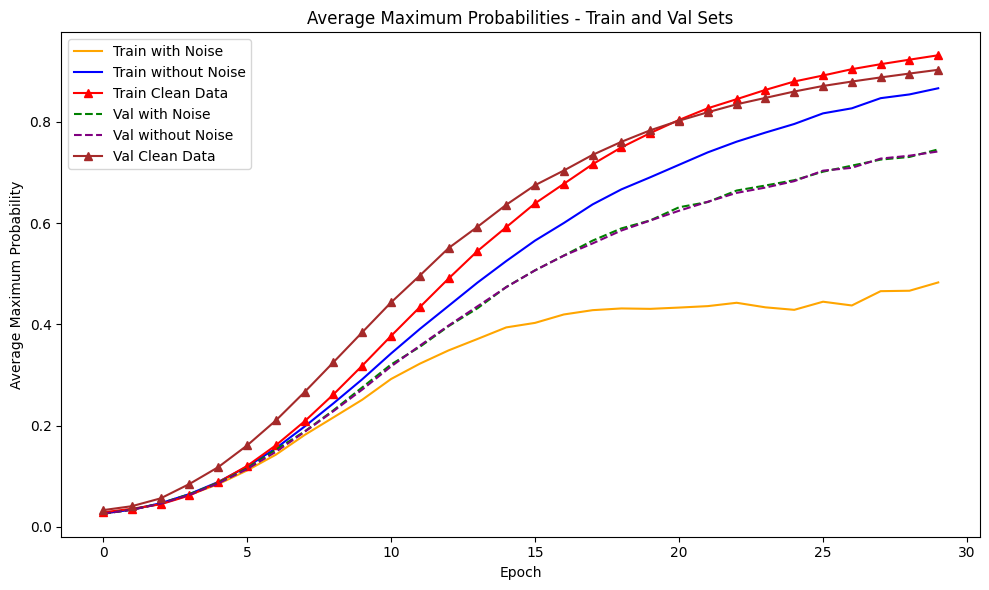

In [ ]:
# Calculate the maximum probability for each batch and then average them for each epoch
avg_max_probs_train_noised = epoch_train_noised_df.apply(lambda x: np.mean([np.max(batch_probs) for batch_probs in x]), axis=0)
avg_max_probs_train_non_noised = epoch_train_non_noised_df.apply(lambda x: np.mean([np.max(batch_probs) for batch_probs in x]), axis=0)
avg_max_probs_test_noised = epoch_test_noised_df.apply(lambda x: np.mean([np.max(batch_probs) for batch_probs in x]), axis=0)
avg_max_probs_test_non_noised = epoch_test_non_noised_df.apply(lambda x: np.mean([np.max(batch_probs) for batch_probs in x]), axis=0)

# Plot the average maximum probabilities for train and test sets with and without noise
plt.figure(figsize=(12, 8))

# Combine the average maximum probabilities for train and test sets
train_with_noise = avg_max_probs_train_noised.values
train_without_noise = avg_max_probs_train_non_noised.values
test_with_noise = avg_max_probs_test_noised.values
test_without_noise = avg_max_probs_test_non_noised.values

# Create subplots
plt.figure(figsize=(10, 6))

# Plot for train set
plt.plot(train_with_noise, label='Train with Noise', color='orange')
plt.plot(train_without_noise, label='Train without Noise', color='blue')
plt.plot(train, label="Train Clean Data", marker = '^', color='red')
plt.title('Average Maximum Probabilities - Train and Val Sets')
plt.xlabel('Epoch')
plt.ylabel('Average Maximum Probability')
plt.legend()

# Plot for test set
plt.plot(test_with_noise, label='Val with Noise', linestyle='dashed', color='green')
plt.plot(test_without_noise, label='Val without Noise', linestyle='dashed', color='purple')
plt.plot(test, label='Val Clean Data', marker = '^', color='brown')
plt.title('Average Maximum Probabilities - Train and Val Sets')
plt.xlabel('Epoch')
plt.ylabel('Average Maximum Probability')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
print(len(epoch_train_noised_df), len(epoch_train_non_noised_df), len(epoch_test_noised_df), len(epoch_test_non_noised_df))

467 4534 469 4533


In [ ]:
# Concatenate probabilities_df onto the end of sampled_data
df = pd.concat([df_train.reset_index(drop=True), probabilities_df_dn], axis=1)

df.to_csv('/content/drive/MyDrive/Zeta Test/Dn.csv')

## Step 2: LSTM Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=30, num_layers=2, num_classes=2, dropout_prob=0):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(p=dropout_prob)  # Add dropout layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)  # Apply dropout
        out = self.fc(out[:, -1, :])
        return out

def main(df):
    # Load dataset for training
    td = np.stack(df.iloc[:, -30:].values.tolist())  # Extract only training dynamics
    td = np.array([[ast.literal_eval(j) for j in i] for i in td])

    is_noisy = df['k'].values.astype(np.int64)
    td = torch.tensor(td, dtype=torch.float)

    # Define model
    net = LSTM(77).cuda()

    # Convert to tensors
    train_x = td.float()
    train_y = torch.from_numpy(is_noisy).long()

    # Split data into train and validation sets
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

    train_dataset = TensorDataset(train_x, train_y)
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

    val_dataset = TensorDataset(val_x, val_y)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

    class_weights = torch.tensor([1.0, 3.0]).to('cuda')  # Adjusted weights for class imbalance

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(net.parameters(), lr=0.004, weight_decay=4e-05)  # Adjusted learning rate

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.9)

    max_epoch = 25
    best_val_acc = 0

    for epoch in range(max_epoch):
        net.train()
        loss_sigma = 0.0
        correct = 0.0
        total = 0.0

        for i, (train_data, train_label) in enumerate(train_dataloader):
            train_data, train_label = Variable(train_data).cuda(), Variable(train_label).cuda()
            optimizer.zero_grad()
            out = net(train_data)
            loss = criterion(out, train_label)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(out.data, 1)
            total += train_label.size(0)
            correct += (predicted == train_label).squeeze().sum().cpu().numpy()
            loss_sigma += loss.item()

        train_accuracy = correct / total

        # Validation
        net.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_data_batch, val_label_batch in val_dataloader:
                val_data_batch, val_label_batch = val_data_batch.cuda(), val_label_batch.cuda()
                val_outputs = net(val_data_batch)
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_label_batch.size(0)
                val_correct += (val_predicted == val_label_batch).sum().item()

        val_accuracy = val_correct / val_total

        print("Epoch [{}/{}] | Train Loss: {:.4f} | Train Acc: {:.2f}% | Val Acc: {:.2f}%".format(
            epoch + 1, max_epoch, loss_sigma, train_accuracy * 100, val_accuracy * 100))

        # Update scheduler
        scheduler.step(loss_sigma)
        current_lr = scheduler.get_last_lr()[0]
        print(f"Current learning rate: {current_lr}")

        # Save the model if validation accuracy improves
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(net.state_dict(), 'best_model.pt')

    return net

if __name__ == "__main__":
    # Replace 'df' with your actual data
    df = pd.read_csv('/content/drive/MyDrive/Zeta Test/Dn.csv')
    net = main(df)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/25] | Train Loss: 132.0203 | Train Acc: 90.83% | Val Acc: 90.01%
Current learning rate: 0.004
Epoch [2/25] | Train Loss: 130.5089 | Train Acc: 90.83% | Val Acc: 90.01%
Current learning rate: 0.004
Epoch [3/25] | Train Loss: 130.4475 | Train Acc: 90.83% | Val Acc: 90.01%
Current learning rate: 0.004
Epoch [4/25] | Train Loss: 128.6318 | Train Acc: 90.83% | Val Acc: 90.01%
Current learning rate: 0.004
Epoch [5/25] | Train Loss: 126.5950 | Train Acc: 90.83% | Val Acc: 90.01%
Current learning rate: 0.004
Epoch [6/25] | Train Loss: 123.1462 | Train Acc: 90.70% | Val Acc: 90.01%
Current learning rate: 0.004
Epoch [7/25] | Train Loss: 120.4749 | Train Acc: 90.80% | Val Acc: 88.91%
Current learning rate: 0.004
Epoch [8/25] | Train Loss: 117.3484 | Train Acc: 90.05% | Val Acc: 89.11%
Current learning rate: 0.004
Epoch [9/25] | Train Loss: 113.7693 | Train Acc: 89.88% | Val Acc: 88.01%
Current learning rate: 0.004
Epoch [10/25] | Train Loss: 108.8846 | Train Acc: 89.55% | Val Acc: 87.71

## Step 3: Retrain BERT on Test Set

0       There is the same transaction showing more tha...
1       How can correct Top up with the app to work co...
2                     How fast are transfers from Europe?
3           Is the fee with my cash withdrawal a mistake?
4              Is there a way for me to check my balance?
                              ...                        
4997     how do i get into my account and edit my details
4998                    What is the maximum I can top up?
4999                          I cancelled my card payment
5000    I need to order a new card as my other one was...
5001          Why did I get charged for withdrawing cash?
Name: text, Length: 5002, dtype: object

In [ ]:
# # Import train data
# test = pd.read_csv('/content/drive/MyDrive/Zeta Test/test.csv')

# # Separate train labels and text
# test_labels = test['category']
# test_text = test['text']

In [ ]:
# full_noised_test_labels, test_noise_indices = add_noise(test_labels)

In [ ]:
device_name = 'cuda'
model_name = 'bert-base-uncased'

# Tokenize input text
tokenizer = BertTokenizer.from_pretrained(model_name)

# Tokenize and encode the testing text
test_input_text = np.array(test_text)
test_input_ids = tokenizer.batch_encode_plus(test_input_text, padding=True, truncation=True, return_tensors='pt')['input_ids']
test_attention_mask = tokenizer.batch_encode_plus(test_input_text, padding=True, truncation=True, return_tensors='pt')['attention_mask']

# Encode labels
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(full_noised_test_labels)

# Convert encoded labels to tensors
test_labels = torch.tensor(test_labels_encoded)

# Split the dataset into train and validation sets
#train_input_ids, val_input_ids, train_attention_mask, val_attention_mask, train_labels, val_labels = train_test_split(train_input_ids, train_attention_mask, train_labels, test_size=0.2, random_state=42)

# Create TensorDatasets
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
#val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)

In [ ]:
# Load pre-trained model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=77).to(device_name)

# Define optimizer with Adam
optimizer = AdamW(model.parameters(), lr=8e-6, weight_decay=2e-4)
#old lr #5e-5

# Define loss function (cross-entropy loss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define training parameters
num_epochs = 30
batch_size = 32

# DataLoader for training set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize a DataFrame to store the probabilities
probabilities_df_dc = pd.DataFrame()
all_preds = []
epoch_true_probs_dc = pd.DataFrame()

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    epoch_probs = []  # List to store probabilities for this epoch
    epoch_true_probs = [] # List to store true probabilities for this epoch

    for batch in tqdm(test_loader, desc=f"Epoch {epoch+1}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device_name), attention_mask.to(device_name), labels.to(device_name)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)  # Calculate cross-entropy loss
        total_loss += loss.item()

        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Calculate probabilities from logits
        true_label_probs = probs[range(len(labels)), labels].detach().cpu().numpy()
        epoch_true_probs.extend(true_label_probs.tolist())
        epoch_probs.extend(probs.detach().cpu().numpy().tolist())  # Append probabilities to the list for this epoch

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

        loss.backward()
        optimizer.step()

    # Evaluate the train set
    train_loss = total_loss / len(train_loader)
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Train Epoch {epoch+1}, Loss: {train_loss}, F1 Score: {train_f1}")

    # Add the probabilities of this epoch to the DataFrame
    probabilities_df_dc[f'Epoch_{epoch+1}'] = pd.Series(epoch_probs)
    epoch_true_probs_dc[f'Epoch_{epoch+1}'] = pd.Series(epoch_true_probs)

    # Switch model to evaluation mode for validation
    # model.eval()
    # with torch.no_grad():
    #     val_loss, val_preds, val_labels = evaluate(model, val_loader)
    #     val_f1 = f1_score(val_labels, val_preds, average='macro')
    #     print(f"Validation Epoch {epoch+1}, Loss: {val_loss}, F1 Score: {val_f1}")

    # # Switch model back to training mode
    # model.train()

# Save the DataFrame to a CSV file
probabilities_df_dc.to_csv('/content/drive/MyDrive/Zeta Test/probabilities_df_dc_noised.csv', index=False)
epoch_true_probs_dc.to_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_dc_noised.csv', index=False)

# Specify a directory to save the model
save_directory = "/content/drive/MyDrive/Zeta Test"

# Save the model
# model.save_pretrained(save_directory, 'model2_test_csv')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1:   1%|▏         | 2/157 [00:21<27:47, 10.76s/it]


KeyboardInterrupt: 

In [ ]:
# Create a DataFrame
df_test = pd.DataFrame({
    'text': test_text,
    'category': full_noised_test_labels,
    'k': 0
})

df_test.loc[test_noise_indices, 'k'] = 1

probabilities_df_dc_noised = pd.read_csv('/content/drive/MyDrive/Zeta Test/probabilities_df_dc_noised.csv')

# Concatenate probabilities_df onto the end of sampled_data
df_clean = pd.concat([df_test.reset_index(drop=True), probabilities_df_dc_noised], axis=1)

df_clean.to_csv('/content/drive/MyDrive/Zeta Test/Dc_noised.csv')

In [ ]:
df_clean = pd.read_csv('/content/drive/MyDrive/Zeta Test/Dc_noised.csv')

td_clean = np.stack(df_clean.iloc[:, -30:].values.tolist())
td_clean = np.array([[ast.literal_eval(j) for j in i] for i in td_clean])
td_clean = torch.tensor(td_clean, dtype=torch.float)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
      dtype=object)

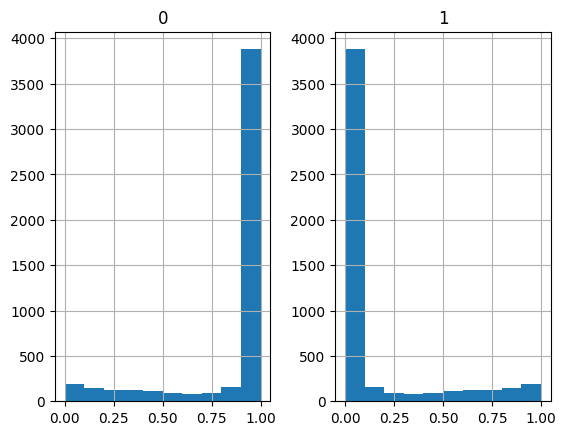

In [ ]:
def predict_probs(net, input_data):
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Temporarily set all the requires_grad flag to false
        input_data = input_data.cuda()
        outputs = net(input_data)
        probabilities = torch.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

pd.DataFrame(predict_probs(net, td_clean)).hist()

In [ ]:
predictions = []
for prob in predict_probs(net, td_clean):
  if prob[1] > 0.67:
    predictions.append(1)
  else:
    predictions.append(0)

print(sum(predictions)/len(predictions))

df_clean = pd.read_csv('/content/drive/MyDrive/Zeta Test/Dc_noised.csv')
# Assuming df is your DataFrame
df_clean.insert(3, 'predictions', predictions)
df_clean.to_csv('/content/drive/MyDrive/Zeta Test/dc_predictions_df.csv')

0.09976009596161535


In [ ]:
pd.options.display.max_rows = 500
df_clean[df_clean['predictions']==1].to_csv('/content/drive/MyDrive/Zeta Test/final_LSTM_incorrect_output.csv')

In [ ]:
output = pd.read_csv('/content/drive/MyDrive/Zeta Test/final_LSTM_incorrect_output.csv')

In [ ]:
full_output = pd.read_csv('/content/drive/MyDrive/Zeta Test/dc_predictions_df.csv')

In [ ]:
correct = 0
rows = 0

for index, row in full_output.iterrows():
    if row['predictions'] == row['k']:
        correct += 1
    rows += 1

print('accuracy: ', correct / rows)

accuracy:  0.8276689324270292


In [ ]:
correct = 0
rows = 0

for index, row in output.iterrows():
    if row['predictions'] == row['k']:
        correct += 1
    rows += 1

print('precision: ', correct / rows)

precision:  0.1062124248496994


In [ ]:
# Calculate accuracy
correct = 0
rows = 0

for index, row in full_output.iterrows():
    if row['predictions'] == row['k']:
        correct += 1
    rows += 1

accuracy = correct / rows

# Calculate precision
correct = 0
rows = 0

for index, row in output.iterrows():
    if row['predictions'] == row['k']:
        correct += 1
    rows += 1

precision = correct / rows

# Example data (replace with your actual values)
categories = ['Accuracy', 'Precision']
scores = [accuracy, precision]

# Create grouped bar plot
plt.bar(categories, scores, color=['blue', 'green'], height=1)

# Labels and title
plt.ylabel('Score')
plt.title('Accuracy and Precision')

# Show plot
plt.show()

TypeError: bar() got multiple values for argument 'height'

In [ ]:
epoch_true_probs_dn = pd.read_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_dn.csv')
epoch_true_probs_clean_train = pd.read_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_dc_noised.csv')

dn_true_label_means_per_epoch_noisy_train = epoch_true_probs_dn.mean(axis=0)
dn_true_label_means_per_epoch_clean_train = epoch_true_probs_clean_train.mean(axis=0)

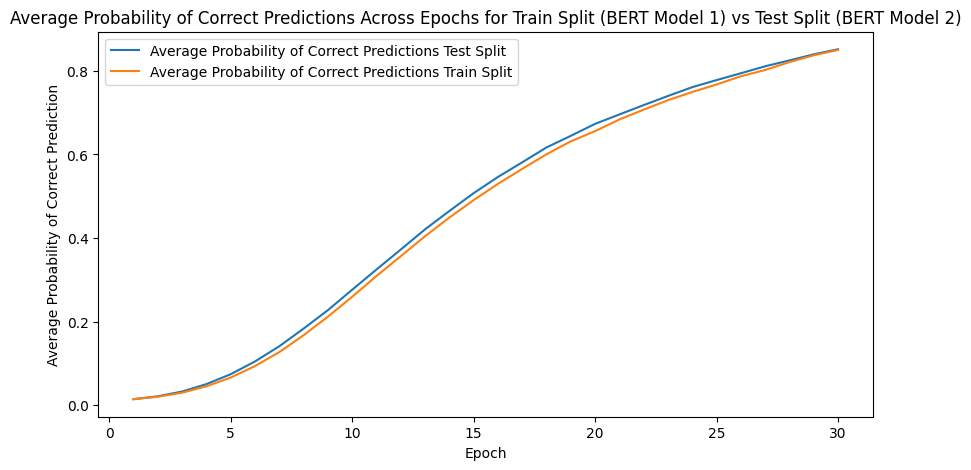

In [ ]:
# Plotting
epochs = list(range(1, 31))
plt.figure(figsize=(10, 5))
plt.plot(epochs, dn_true_label_means_per_epoch_clean_train, label='Average Probability of Correct Predictions Test Split')
plt.plot(epochs, dn_true_label_means_per_epoch_noisy_train, label='Average Probability of Correct Predictions Train Split')
plt.xlabel('Epoch')
plt.ylabel('Average Probability of Correct Prediction')
plt.title('Average Probability of Correct Predictions Across Epochs for Train Split (BERT Model 1) vs Test Split (BERT Model 2)')
plt.legend()
plt.show()

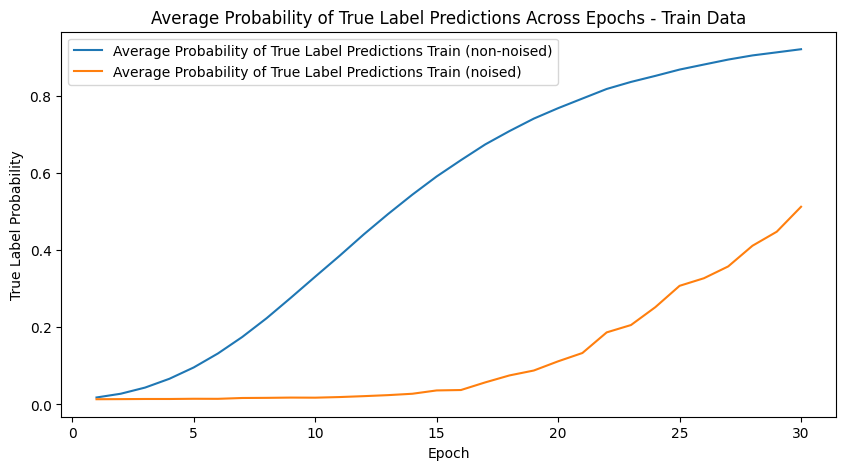

In [ ]:
true_non_noised_train = epoch_true_probs_non_noised_train.mean(axis=0).values[1:]
true_noised_train = epoch_true_probs_noised_train.mean(axis=0).values[1:]

# Plotting
epochs = list(range(1, 31))
plt.figure(figsize=(10, 5))
plt.plot(epochs, true_non_noised_train, label='Average Probability of True Label Predictions Train (non-noised)')
plt.plot(epochs, true_noised_train, label='Average Probability of True Label Predictions Train (noised)')
plt.xlabel('Epoch')
plt.ylabel('True Label Probability')
plt.title('Average Probability of True Label Predictions Across Epochs - Train Data')
plt.legend()
plt.show()

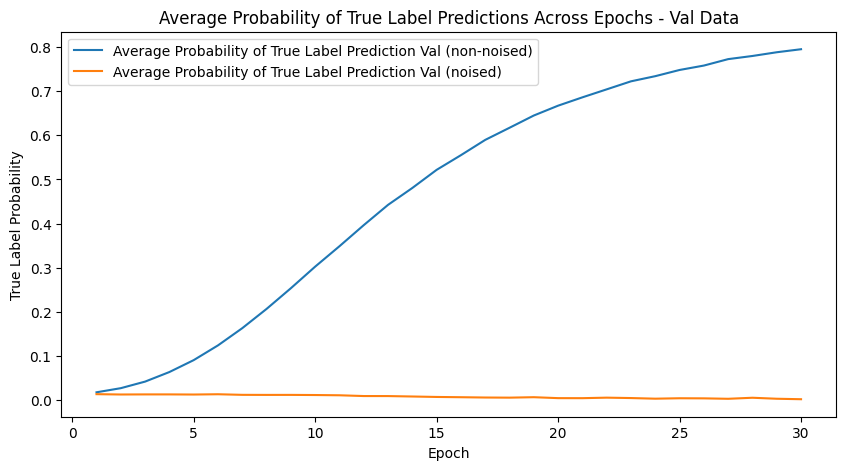

In [ ]:
true_non_noised_test = epoch_true_probs_non_noised_test_df.mean(axis=0).values[1:]
true_noised_test = epoch_true_probs_noised_test_df.mean(axis=0).values[1:]

# Plotting
epochs = list(range(1, 31))
plt.figure(figsize=(10, 5))
plt.plot(epochs, true_non_noised_test, label='Average Probability of True Label Prediction Val (non-noised)')
plt.plot(epochs, true_noised_test, label='Average Probability of True Label Prediction Val (noised)')
plt.xlabel('Epoch')
plt.ylabel('True Label Probability')
plt.title('Average Probability of True Label Predictions Across Epochs - Val Data')
plt.legend()
plt.show()

record noised test true label probabilities


In [ ]:
len(df_clean)

5002

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

train_text_probs = pd.DataFrame(predict_probs(net, td_clean))
print(train_text_probs.shape)
#df_clean

# Split data into train and test sets

#X_train, X_test, y_train, y_test = train_test_split(df_clean['predictions'], df_clean['k'], test_size=0.2, random_state=13)
X_train, X_test, y_train, y_test = train_test_split(train_text_probs, df_clean['k'], test_size=0.2, random_state=13)

# Convert data into DMatrix format (required by XGBoost)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters for XGBoost model
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',         # Evaluation metric
    'max_depth': 6,                   # Maximum tree depth
    'eta': 0.3,                       # Learning rate
    'subsample': 0.8,                 # Subsample ratio of the training instances
    'colsample_bytree': 0.8,          # Subsample ratio of columns when constructing each tree
    'seed': 8                        # Random seed
}

# Training the model
num_round = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_round)

# Predictions on the test set
preds = model.predict(dtest)
predictions = [round(value) for value in preds]

# Evaluate model accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100.0:.2f}%")

(5002, 2)
Accuracy: 89.61%


# Scrap code - disregard

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=30, num_layers=2, num_classes=2, dropout_prob=0):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(p=dropout_prob)  # Add dropout layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)  # Apply dropout
        out = self.fc(out[:, -1, :])
        return out

def main(df):
    # load dataset for training
    td = np.stack(df.iloc[:, -30:].values.tolist())  # extract only training dynamics
    #print(td.shape, td)
    td = np.array([[ast.literal_eval(j) for j in i] for i in td])

    print(td.shape)
    is_noisy = df['k'].values.astype(np.int64)
    td = torch.tensor(td, dtype=torch.float)
    print('Using input type with shape of', td.shape)

    # define model
    net = LSTM(77).cuda()  # assuming each of the 77 probabilities is a feature
    print('Training detector instanced by', net.__class__.__name__)

     # Convert to tensors
    train_x = td.float()
    train_y = torch.from_numpy(is_noisy).long()

    train_dataset = TensorDataset(train_x, train_y)
    train_dataloader = DataLoader(train_dataset, batch_size=15, shuffle=True, num_workers=4)

    class_weights = torch.tensor([1.0, 3.0]).to('cuda')  # class 1 gets more weight

    # define loss and optimizer
    # Compute class weights
    criterion = nn.CrossEntropyLoss(weight = class_weights)
    optimizer = AdamW(net.parameters(), lr= 0.0038) #0.0038
    max_epoch = 35
    best_prec = 0

    for epoch in range(max_epoch):
        net.train()
        loss_sigma = 0.0  #
        correct = 0.0
        total = 0.0
        for i, (train_data, train_label) in enumerate(train_dataloader):
            train_data, train_label = Variable(train_data).cuda(), Variable(train_label).cuda()
            out = net(train_data)

            loss = criterion(out, train_label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(out.data, 1)
            total += train_label.size(0)
            correct += (predicted == train_label).squeeze().sum().cpu().numpy()
            loss_sigma += loss.item()

        print("Training: Epoch[{:0>3}/{:0>3}]  Loss: {:.4f} Acc:{:.2%}".format(
            epoch + 1, max_epoch, loss_sigma, correct / total))

    return net

# Load your DataFrame here
df = pd.read_csv('/content/drive/MyDrive/Zeta Test/Dn.csv')

net = main(df)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    epoch_probs = []  # List to store probabilities for this epoch
    epoch_true_probs = [] # List to store true probabilities for this epoch

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device_name), attention_mask.to(device_name), labels.to(device_name)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)  # Calculate cross-entropy loss
        total_loss += loss.item()

        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Calculate probabilities from logits
        true_label_probs = probs[range(len(labels)), labels].detach().cpu().numpy()
        epoch_true_probs.extend(true_label_probs.tolist())
        epoch_probs.extend(probs.detach().cpu().numpy().tolist())  # Append probabilities to the list for this epoch

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

        loss.backward()
        optimizer.step()

    # Evaluate the train set
    train_loss = total_loss / len(train_loader)
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Train Epoch {epoch+1}, Loss: {train_loss}, F1 Score: {train_f1}")

    # Add the probabilities of this epoch to the DataFrame
    probabilities_df_dn[f'Epoch_{epoch+1}'] = pd.Series(epoch_probs)
    epoch_true_probs_dn[f'Epoch_{epoch+1}'] = pd.Series(epoch_true_probs)

    # Switch model to evaluation mode
    model.eval()

    # Evaluate the whole test set
    test_loss, test_preds, test_labels = evaluate(model, test_loader)
    print(f"Test Epoch {epoch+1}, Loss: {test_loss}, F1 Score: {f1_score(test_labels, test_preds, average='macro')}")

    # Evaluate the noised part of the test set
    test_loss_noised, test_preds_noised, test_labels_noised = evaluate(model, test_loader_noised)
    print(f"Test Epoch {epoch+1} (Noised), Loss: {test_loss_noised}, F1 Score: {f1_score(test_labels_noised, test_preds_noised, average='macro')}")

    # Evaluate the non-noised part of the test set
    test_loss_non_noised, test_preds_non_noised, test_labels_non_noised = evaluate(model, test_loader_non_noised)
    print(f"Test Epoch {epoch+1} (Non-Noised), Loss: {test_loss_non_noised}, F1 Score: {f1_score(test_labels_non_noised, test_preds_non_noised, average='macro')}")

    # Switch model back to training mode
    model.train()

# Save the probabilities to a CSV file
probabilities_df_dn.to_csv('/content/drive/MyDrive/Zeta Test/probabilities_df_dn.csv', index=False)

# Save the true label probabilities to CSV
epoch_true_probs_dn.to_csv('/content/drive/MyDrive/Zeta Test/epoch_true_probs_dn.csv', index=False)

# Specify a directory to save the model
save_directory = "/content/drive/MyDrive/Zeta Test"

# Save the model
# model.save_pretrained(save_directory, 'model1_train_csv')

In [ ]:
# Tokenize and encode the testing text
train_input_text = np.array(test_text)
train_input_ids = tokenizer.batch_encode_plus(train_input_text, padding=True, truncation=True, return_tensors='pt')['input_ids']
train_attention_mask = tokenizer.batch_encode_plus(train_input_text, padding=True, truncation=True, return_tensors='pt')['attention_mask']

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(test_labels)

# Convert encoded labels to tensors
train_labels = torch.tensor(train_labels_encoded)

# Create TensorDatasets
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)

# Split the dataset into train and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load pre-trained model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=77).to(device_name)

# Define optimizer with Adam
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Define loss function (cross-entropy loss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define training parameters
num_epochs = 20
batch_size = 15

# DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize a DataFrame to store the probabilities
dc_probabilities_df = pd.DataFrame()
all_preds = []
epoch_true_probs1 = pd.DataFrame()

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    epoch_probs = []  # List to store probabilities for this epoch
    epoch_true_probs = [] # List to store true probabilities for this epoch

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device_name), attention_mask.to(device_name), labels.to(device_name)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)  # Calculate cross-entropy loss
        total_loss += loss.item()

        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Calculate probabilities from logits
        true_label_probs = probs[range(len(labels)), labels].detach().cpu().numpy()
        epoch_true_probs.extend(true_label_probs.tolist())
        epoch_probs.extend(probs.detach().cpu().numpy().tolist())  # Append probabilities to the list for this epoch

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

        loss.backward()
        optimizer.step()

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch {epoch+1}, Loss: {total_loss}, F1 Score: {f1}")

    # Add the probabilities of this epoch to the DataFrame
    epoch_true_probs1[f'Epoch_{epoch+1}'] = pd.Series(epoch_true_probs)
    dc_probabilities_df[f'Epoch_{epoch+1}'] = pd.Series(epoch_probs)


# # Save the DataFrame to a CSV file
# probabilities_df.to_csv('/content/drive/MyDrive/Zeta Test/probabilities.csv', index=False)

# # Specify a directory to save the model
# save_directory = "/content/drive/MyDrive/Zeta Test"

# # Save the model
# model.save_pretrained(save_directory)

In [ ]:
# Load pre-trained model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=77).to(device_name)

# Define optimizer with Adam
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Define loss function (cross-entropy loss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define training parameters
num_epochs = 40
batch_size = 15

# DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# List to store probabilities per epoch
probabilities_per_epoch = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    epoch_probs = []  # List to store probabilities for this epoch

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device_name), attention_mask.to(device_name), labels.to(device_name)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)  # Calculate cross-entropy loss
        total_loss += loss.item()

        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Calculate probabilities from logits
        epoch_probs.append(probs.detach().cpu().numpy())  # Append probabilities to the list for this epoch

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

        loss.backward()
        optimizer.step()

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch {epoch+1}, Loss: {total_loss}, F1 Score: {f1}")

    # Append probabilities for this epoch to the list
    probabilities_per_epoch.append(epoch_probs)

# Convert probabilities_per_epoch to a NumPy array for easier manipulation
probabilities_array = np.array(probabilities_per_epoch)


# Specify a directory to save the model
save_directory = "/content/drive/MyDrive/Zeta Test"

# Save the model
model.save_pretrained(save_directory)


In [ ]:
print(probabilities_array.shape)
max(probabilities_array[0][40][0])

In [ ]:
max_probs = []
for epoch in probabilities_array:
  for batch in epoch:
    for sample in batch:
      max_probs.append(max(sample))

len(max_probs)

In [ ]:
# Assuming probabilities_array has shape (num_epochs, batch_size, num_samples, num_classes)
num_epochs, batch_size, num_samples, num_classes = probabilities_array.shape

# Reshape probabilities_array to have separate dimensions for epochs, samples, and classes
consolidated_probabilities = probabilities_array.reshape(num_epochs, -1, num_classes)

consolidated_probabilities.shape

# Calculate the maximum probability for each epoch
max_probs_per_epoch = np.max(consolidated_probabilities, axis=(1, 2))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_probs_per_epoch, color='blue', label='Max Probability per Epoch')
plt.title('Max Probabilities over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Max Probability')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epoch_probs[0].shape
len(probabilities_per_epoch[0])

In [ ]:
# List to store probabilities of true label per epoch
true_label_probs_per_epoch = []

for epoch_probs in probabilities_per_epoch:
    true_label_probs_batch = []
    for batch_probs, batch_labels in zip(epoch_probs, all_labels):
        true_label_prob = batch_probs[batch_labels].tolist()  # Probability corresponding to the true label
        true_label_probs_batch.extend(true_label_prob)
    true_label_probs_per_epoch.append(true_label_probs_batch)

# Convert true_label_probs_per_epoch to a NumPy array for easier manipulation
true_label_probs_array = np.array(true_label_probs_per_epoch)

# Calculate mean probability of true label per epoch
mean_true_label_probs_per_epoch = np.mean(true_label_probs_array, axis=1)

# Calculate standard deviation of probability of true label per epoch
std_true_label_probs_per_epoch = np.std(true_label_probs_array, axis=1)

print("Mean probability assigned to the actual true label per epoch:")
print(mean_true_label_probs_per_epoch)

print("Standard deviation of probability assigned to the actual true label per epoch:")
print(std_true_label_probs_per_epoch)


In [ ]:
# List to store probabilities of true label per epoch
true_label_probs_per_epoch = []

for epoch_probs in probabilities_per_epoch:
    true_label_probs = []
    for i, prob in enumerate(epoch_probs):
        true_label_index = all_labels[prob]  # Get the true label index
        true_label_prob = prob[true_label_index].item()  # Probability corresponding to the true label
        true_label_probs.append(true_label_prob)
    true_label_probs_per_epoch.append(true_label_probs)

# Convert true_label_probs_per_epoch to a NumPy array for easier manipulation
true_label_probs_array = np.array(true_label_probs_per_epoch)

# Calculate mean probability of true label per epoch
mean_true_label_probs_per_epoch = np.mean(true_label_probs_array, axis=1)

# Calculate standard deviation of probability of true label per epoch
std_true_label_probs_per_epoch = np.std(true_label_probs_array, axis=1)

print("Mean probability assigned to the actual true label per epoch:")
print(mean_true_label_probs_per_epoch)

print("Standard deviation of probability assigned to the actual true label per epoch:")
print(std_true_label_probs_per_epoch)


In [ ]:
# Save the trained model
model.save_pretrained("/content/drive/MyDrive/Zeta Test")

In [ ]:
# Old model with validation set

# Load pre-trained model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=77).to(device_name)

# Define optimizer with Adam
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

# Define loss function (cross-entropy loss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define training parameters
num_epochs = 100
batch_size = 16

# Split dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# List to store probabilities per epoch
probabilities_per_epoch = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    epoch_probs = []  # List to store probabilities for this epoch

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device_name), attention_mask.to(device_name), labels.to(device_name)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)  # Calculate cross-entropy loss
        total_loss += loss.item()

        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Calculate probabilities from logits
        epoch_probs.append(probs.detach().cpu().numpy())  # Append probabilities to the list for this epoch

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds_val = []
    all_labels_val = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device_name), attention_mask.to(device_name), labels.to(device_name)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds_val.extend(preds.cpu().tolist())
            all_labels_val.extend(labels.cpu().tolist())

    # Calculate F1 score
    f1 = f1_score(all_labels_val, all_preds_val, average='macro')

    print(f"Epoch {epoch+1}, Loss: {total_loss}, F1 Score: {f1}")

    # Append probabilities for this epoch to the list
    probabilities_per_epoch.append(epoch_probs)

# Convert probabilities_per_epoch to a NumPy array for easier manipulation
probabilities_array = np.array(probabilities_per_epoch)